In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# === Cell 1: Setup & paths ===
import os, random, gc, time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

ROOT = "/kaggle/input/zindispotthemaskchallenge"
labels = pd.read_csv(f"{ROOT}/train_labels.csv")   # columns: image, target (0/1)
print("Samples:", len(labels))
print(labels.head())

# Auto-detect nested image folder (sometimes images/images)
candidates = [ROOT, f"{ROOT}/images", f"{ROOT}/images/images"]
BASE_DIR = None
for c in candidates:
    if os.path.exists(os.path.join(c, labels.loc[0, "image"])):
        BASE_DIR = c; break
assert BASE_DIR is not None, "Could not find images folder"
print("Using BASE_DIR:", BASE_DIR)


Samples: 1308
                                image  target
0  tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg       0
1  rxgismgsvmaayzjarbfjaljhqmpbrt.jpg       1
2  uuzshfrhkgrkolhwdvliqauzulurnz.jpg       0
3  mjspxsagzusaznvnyxgamtrlqkqklp.jpg       0
4  rlbmuajgezfiddjzlyeoupxpqubkpt.jpg       1
Using BASE_DIR: /kaggle/input/zindispotthemaskchallenge/images/images


target
0    664
1    644
Name: count, dtype: int64


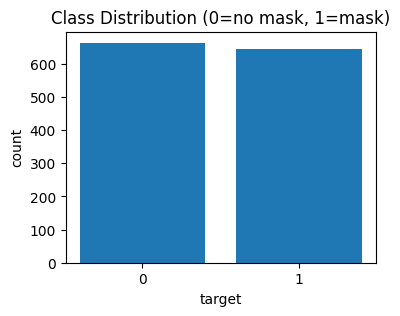

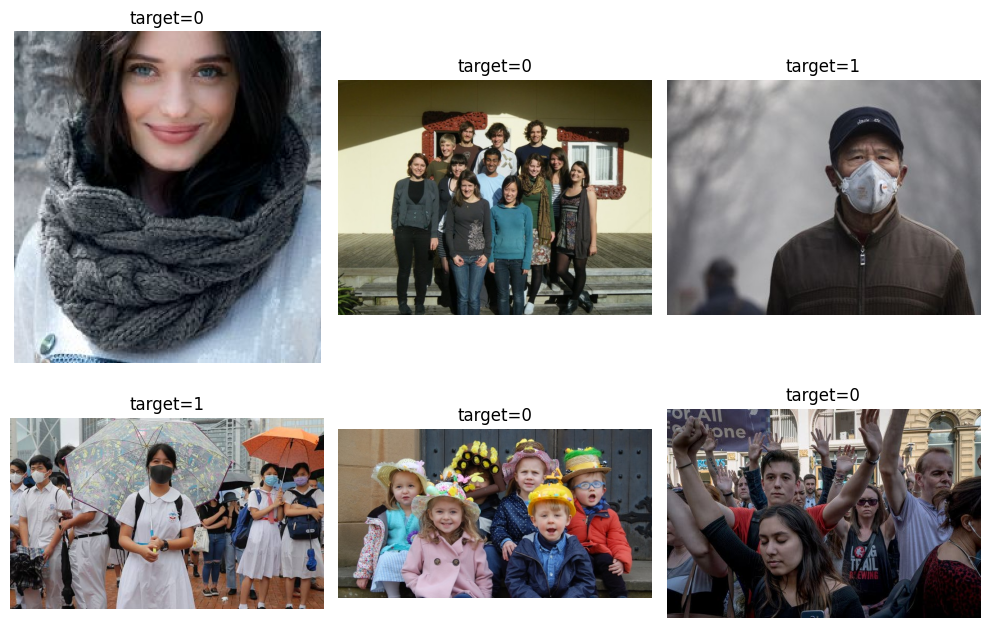

In [7]:
# === Cell 2: EDA (class balance + samples) ===
print(labels["target"].value_counts())

# Quick bar plot
counts = labels["target"].value_counts().sort_index()
plt.figure(figsize=(4,3))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Distribution (0=no mask, 1=mask)")
plt.xlabel("target"); plt.ylabel("count"); plt.show()

# Show 6 random images with labels
sample = labels.sample(6, random_state=SEED)
fig, axes = plt.subplots(2, 3, figsize=(10,7))
for ax, (_, row) in zip(axes.ravel(), sample.iterrows()):
    path = os.path.join(BASE_DIR, row["image"])
    img = Image.open(path).convert("RGB")
    ax.imshow(img); ax.set_title(f"target={row['target']}"); ax.axis("off")
plt.tight_layout(); plt.show()


In [8]:
# === Cell 3: Split + Dataset/Dataloaders ===

# Stratified split (80/20)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(labels["image"], labels["target"]))
df_train = labels.iloc[train_idx].reset_index(drop=True).copy()
df_val   = labels.iloc[val_idx].reset_index(drop=True).copy()
print("Train:", df_train.shape, " Val:", df_val.shape)

IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class MaskCsvDataset(Dataset):
    def __init__(self, df, base_dir, transform=None, has_target=True):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform
        self.has_target = has_target
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(os.path.join(self.base_dir, row["image"])).convert("RGB")
        if self.transform: img = self.transform(img)
        if self.has_target:
            label = torch.tensor(int(row["target"]), dtype=torch.long)
            return img, label
        else:
            return img, row["image"]

BATCH_SIZE = 32
train_ds = MaskCsvDataset(df_train, BASE_DIR, train_tfms, has_target=True)
val_ds   = MaskCsvDataset(df_val,   BASE_DIR, val_tfms,   has_target=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Train: (1046, 2)  Val: (262, 2)


In [9]:
# === Cell 4: Model + training loop ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FREEZE_BACKBONE = False   # set True for faster training (fine-tune only head)
EPOCHS = 10
LR = 3e-4

model = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V1")
if FREEZE_BACKBONE:
    for p in model.features.parameters():
        p.requires_grad = False
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def run_epoch(dloader, train=True):
    model.train(mode=train)
    total_loss, correct, n = 0.0, 0, 0
    for x,y in dloader:
        x,y = x.to(device), y.to(device)
        if train: optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        n += x.size(0)
    return total_loss/n, correct/n

BEST_PATH = "best_mobilenetv2.pt"
best_val = 0.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    va_loss, va_acc = run_epoch(val_dl,   False)
    scheduler.step()
    if va_acc > best_val:
        best_val = va_acc
        torch.save(model.state_dict(), BEST_PATH)
    print(f"Epoch {epoch:02d}/{EPOCHS}  |  train {tr_loss:.4f}/{tr_acc:.3f}  |  val {va_loss:.4f}/{va_acc:.3f}  |  best {best_val:.3f}")
print("Best val acc:", best_val)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d5f8374e980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d5f8374e980> 
 ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^ ^^ ^ ^  ^^ ^^^^^^^

Epoch 01/10  |  train 0.2297/0.906  |  val 0.2543/0.931  |  best 0.931
Epoch 02/10  |  train 0.0932/0.970  |  val 0.1101/0.966  |  best 0.966
Epoch 03/10  |  train 0.0411/0.988  |  val 0.1229/0.962  |  best 0.966
Epoch 04/10  |  train 0.0391/0.986  |  val 0.0836/0.969  |  best 0.969
Epoch 05/10  |  train 0.0522/0.983  |  val 0.0701/0.981  |  best 0.981
Epoch 06/10  |  train 0.0184/0.994  |  val 0.0623/0.985  |  best 0.985
Epoch 07/10  |  train 0.0084/0.999  |  val 0.0569/0.981  |  best 0.985
Epoch 08/10  |  train 0.0084/0.998  |  val 0.0532/0.985  |  best 0.985
Epoch 09/10  |  train 0.0075/0.998  |  val 0.0509/0.989  |  best 0.989
Epoch 10/10  |  train 0.0042/0.999  |  val 0.0506/0.989  |  best 0.989
Best val acc: 0.9885496183206107


In [10]:
# === Cell 5: Evaluation on validation split ===
model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in val_dl:
        x = x.to(device)
        logits = model(x)
        y_true += y.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0     0.9924    0.9850    0.9887       133
           1     0.9846    0.9922    0.9884       129

    accuracy                         0.9885       262
   macro avg     0.9885    0.9886    0.9885       262
weighted avg     0.9886    0.9885    0.9886       262

Confusion matrix:
 [[131   2]
 [  1 128]]


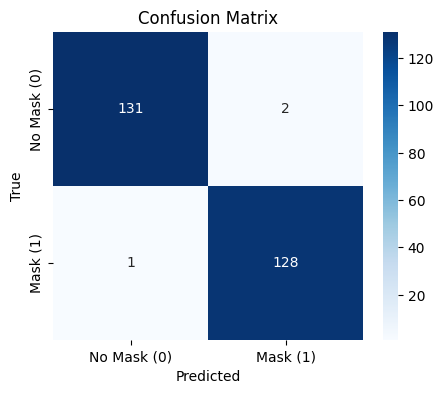

In [11]:
# === Confusion Matrix Plot ===
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Recompute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Mask (0)", "Mask (1)"],
            yticklabels=["No Mask (0)", "Mask (1)"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [15]:
print(sub.columns)


Index(['+ACI-image+ACI-', '+ACI-target+ACI-'], dtype='object')


In [16]:
# 1) Read and clean weird headers/values
sub = pd.read_csv(f"{ROOT}/sample_sub.csv")

# fix column names: '+ACI-image+ACI-' -> 'image', '+ACI-target+ACI-' -> 'target'
sub.columns = (
    sub.columns
      .str.replace(r'\+ACI\-','', regex=True)  # remove +ACI-
      .str.replace('"','', regex=False)        # remove quotes if any
      .str.strip()
)

# fix cell values that look like '+ACI-xxx.jpg+ACI-'
for c in sub.columns:
    if sub[c].dtype == object:
        sub[c] = (
            sub[c].astype(str)
                  .str.replace(r'\+ACI\-','', regex=True)
                  .str.replace('"','', regex=False)
                  .str.strip()
        )

print("Cleaned columns:", list(sub.columns))
print(sub.head())


Cleaned columns: ['image', 'target']
                                image  target
0  aadawlxbmapqrblgxyzarhjasgiobu.png       0
1  abpxvdfyhaaohzcrngcucmhffwizxs.jpg       0
2  aclkjfvackiieiznzfcwienplielrj.jpg       0
3  aelkivmayxgsdjosiibfgmkvfrjvjk.jpg       0
4  aelzzshpfxerelefnkatpczktuxjln.jpg       0


In [17]:
# 2) Locate test images (uses the cleaned 'image' column)
test_candidates = [BASE_DIR, f"{ROOT}/images", f"{ROOT}/images/images"]
TEST_DIR = None
for c in test_candidates:
    if os.path.exists(os.path.join(c, sub.loc[0, "image"])):
        TEST_DIR = c; break
assert TEST_DIR is not None, "Could not locate test images."

# 3) Build test dataset/loader (set num_workers=0 to avoid multiprocessing warning)
test_ds = MaskCsvDataset(sub.copy(), TEST_DIR, transform=val_tfms, has_target=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# 4) Inference -> probabilities for class=1 (mask)
model.eval()
ids, probs = [], []
with torch.no_grad():
    for x, names in test_dl:
        x = x.to(device)
        p1 = model(x).softmax(1)[:,1]
        ids.extend(list(names))
        probs.extend(p1.cpu().numpy())

# 5) Save in the exact format you showed: id,label
submission = pd.DataFrame({"id": ids, "label": probs})
submission.to_csv("submission.csv", index=False)
submission.head()


,id,label
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0.009387
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0.000540
2,aclkjfvackiieiznzfcwienplielrj.jpg,0.999948
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0.999321
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0.005185
